# Blue Bikes Demand Prediction - Linear Regression Model

This notebook builds and evaluates a linear regression model to predict daily trip counts at Blue Bikes stations.

## Contents:
1. **Load and Prepare Data** - Import processed dataset
2. **Train/Test Split** - Split by year (2022-2024 train, 2025 test)
3. **Build Linear Regression** - Train model on selected features
4. **Evaluate Performance** - Calculate RMSE and MAE
5. **Analyze Results** - Feature importance and error analysis
6. **Conclusions** - Summary of findings

---

**Goal:** Predict daily trip count per station using weather and temporal features.

**Model:** Linear Regression (baseline model for comparison with future advanced models)

**Evaluation:** RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) on 2025 test data

## 1. Load and Prepare Data

Import necessary libraries and load the processed dataset.

In [10]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Plot style
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)

print("Libraries imported.")

Libraries imported.


## 2. Load processed dataset

Attempt to load the processed daily dataset. Expects a `date` column and a numeric target such as `trip_count`.

In [11]:
# Robustly resolve processed CSV path(s)
base = Path.cwd()
# Notebook is likely in notebooks/; processed data likely in ../data/processed/
candidates = [
    base / "../data/processed/merged_data.csv",
    base / "../data/processed/sample_merged_data.csv",
]

path = None
for c in candidates:
    if c.exists():
        path = c.resolve()
        break

if path is None:
    raise FileNotFoundError("Could not find processed data. Expected one of: " + ", ".join(map(str, candidates)))

print(f"Loading: {path}")

df = pd.read_csv(path)

# Ensure date column exists and is datetime
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])  # coerce errors if needed
else:
    raise KeyError("Expected a 'date' column in processed dataset.")

# Ensure target exists; default to 'trip_count' if present
candidate_targets = ["trip_count", "count", "rides", "n_trips"]
y_col = next((c for c in candidate_targets if c in df.columns), None)
if y_col is None:
    raise KeyError(f"Could not find target column in {candidate_targets}.")

# Sort by date and drop rows with missing target
if df[y_col].isna().any():
    print(f"Dropping {df[y_col].isna().sum()} rows with NaN {y_col}.")
    df = df.dropna(subset=[y_col])

df = df.sort_values("date").reset_index(drop=True)

# Convenience year column if missing
if "year" not in df.columns:
    df["year"] = df["date"].dt.year

print("Loaded rows:", len(df))
df.head(3)

Loading: /Users/julianlimjunren/Projects/506-final-project/data/processed/merged_data.csv
Loaded rows: 566622


,station_id,start_station_name,date,trip_count,lat,lng,temp_mean,precipitation,wind_speed,snowfall,is_holiday,day_of_week,is_academic_break,month,year
0,351,Faneuil St at Arlington St,2022-01-01,1,42.352766,-71.159885,8.2,2.2,10.2,0.0,1,5,1,1,2022
1,B32008,Boston City Hall - 28 State St,2022-01-01,20,42.358920,-71.057629,8.2,2.2,10.2,0.0,1,5,1,1,2022
2,C32006,Washington St at Rutland St,2022-01-01,18,42.338515,-71.074041,8.2,2.2,10.2,0.0,1,5,1,1,2022


## 3. Train/Test Split (temporal)

As the proposal stated, I will be training on data from 2022-2024, and testing on data from 2025. Note, test set only covers January-September 2025 (9 months). While this doesn't include the full seasonal cycle, the training data contains multiple years of Oct-Dec patterns that the model can learn from.


In [12]:
# Split by year: train on 2022-2024, test on 2025
train = df[df['year'] < 2025].copy()
test = df[df['year'] == 2025].copy()

print("=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)
print(f"\nTraining data (2022-2024):")
print(f"  Rows: {len(train):,}")
print(f"  Date range: {train['date'].min()} to {train['date'].max()}")
print(f"  Unique stations: {train['station_id'].nunique()}")
print(f"  Total trips: {train['trip_count'].sum():,}")

print(f"\nTest data (2025):")
print(f"  Rows: {len(test):,}")
print(f"  Date range: {test['date'].min()} to {test['date'].max()}")
print(f"  Unique stations: {test['station_id'].nunique()}")
print(f"  Total trips: {test['trip_count'].sum():,}")

print(f"\nTrain/Test split: {len(train)/len(df)*100:.1f}% / {len(test)/len(df)*100:.1f}%")
print("=" * 60)

TRAIN/TEST SPLIT

Training data (2022-2024):
  Rows: 432,022
  Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
  Unique stations: 539
  Total trips: 12,200,854

Test data (2025):
  Rows: 134,600
  Date range: 2025-01-01 00:00:00 to 2025-09-30 00:00:00
  Unique stations: 586
  Total trips: 3,566,842

Train/Test split: 76.2% / 23.8%


## 4. Feature Selection

Pick candidate features from weather and calendar; use only those that exist in the data.

In [13]:
# Define features and target
base_features = ['temp_mean', 'precipitation', 'wind_speed', 'snowfall',
                 'day_of_week', 'month', 'is_holiday', 'is_academic_break']

# Add station_id to capture station-specific baseline demand
features_with_station = base_features + ['station_id']

target = 'trip_count'

print("=" * 60)
print("FEATURE PREPARATION")
print("=" * 60)

print("\n📋 Base features (8):")
for i, feat in enumerate(base_features, 1):
    print(f"  {i}. {feat}")

print("\n📍 Adding station_id:")
print("  → Station_id captures baseline demand differences between stations")
print("  → Will be one-hot encoded (creates binary column for each station)")

# Prepare data with station_id
train_with_station = train[features_with_station + [target]].copy()
test_with_station = test[features_with_station + [target]].copy()

# One-hot encode station_id
print("\n🔄 One-hot encoding station_id...")
X_train = pd.get_dummies(train_with_station[features_with_station], columns=['station_id'])
X_test = pd.get_dummies(test_with_station[features_with_station], columns=['station_id'])

# Align train/test columns (ensure same columns in both)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Extract target
y_train = train_with_station[target].copy()
y_test = test_with_station[target].copy()

print(f"✓ One-hot encoding complete")
print(f"  Original features: {len(features_with_station)}")
print(f"  After encoding: {X_train.shape[1]} features")
print(f"  (Added {X_train.shape[1] - len(base_features)} station dummy variables)")

print("\n📊 Feature matrix shapes:")
print(f"  X_train: {X_train.shape} (rows × features)")
print(f"  y_train: {y_train.shape} (target values)")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

print("\n📈 Base feature statistics (training data):")
print(train[base_features].describe().round(2))

print("\n✓ Data prepared and ready for model training")
print("=" * 60)

FEATURE PREPARATION

📋 Base features (8):
  1. temp_mean
  2. precipitation
  3. wind_speed
  4. snowfall
  5. day_of_week
  6. month
  7. is_holiday
  8. is_academic_break

📍 Adding station_id:
  → Station_id captures baseline demand differences between stations
  → Will be one-hot encoded (creates binary column for each station)

🔄 One-hot encoding station_id...
✓ One-hot encoding complete
  Original features: 9
  After encoding: 547 features
  (Added 539 station dummy variables)

📊 Feature matrix shapes:
  X_train: (432022, 547) (rows × features)
  y_train: (432022,) (target values)
  X_test:  (134600, 547)
  y_test:  (134600,)

📈 Base feature statistics (training data):
       temp_mean  precipitation  wind_speed   snowfall  day_of_week  \
count  432022.00      432022.00   432022.00  432022.00    432022.00   
mean       12.16           3.15       20.03       0.14         2.99   
std         9.04           7.52        6.25       1.12         2.00   
min       -16.70           0.00  

## 5. Train Linear Regression

Fit a simple baseline linear regression to available features.

In [14]:
# Initialize and train linear regression model
model = LinearRegression()

print("Training Linear Regression model...")
print(f"  Using {X_train.shape[1]} features ({len(base_features)} base + {X_train.shape[1] - len(base_features)} station dummies)")
model.fit(X_train, y_train)
print("✓ Model trained successfully!")

# Display coefficients for base features only
print("\n" + "=" * 60)
print("MODEL COEFFICIENTS (Base Features)")
print("=" * 60)
print(f"\nIntercept: {model.intercept_:.2f}")

# Extract coefficients for base features (first 8 columns)
base_coef_df = pd.DataFrame({
    'Feature': base_features,
    'Coefficient': model.coef_[:len(base_features)]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nBase Feature Coefficients (sorted by absolute value):")
print(base_coef_df.to_string(index=False))

print("\n📍 Station-specific coefficients:")
print(f"  → {X_train.shape[1] - len(base_features)} station dummy variables")
print(f"  → Each station has its own baseline adjustment")
print(f"  → (Not displayed for brevity)")

print("\nInterpretation:")
print("  Positive coefficient = feature increases trip count")
print("  Negative coefficient = feature decreases trip count")
print("  Station dummies capture baseline demand differences")
print("=" * 60)

Training Linear Regression model...
  Using 547 features (8 base + 539 station dummies)
✓ Model trained successfully!

MODEL COEFFICIENTS (Base Features)

Intercept: 16.18

Base Feature Coefficients (sorted by absolute value):
          Feature  Coefficient
is_academic_break    -7.424865
       is_holiday    -6.719712
        temp_mean     1.223276
    precipitation    -0.483121
      day_of_week    -0.413108
            month     0.292359
       wind_speed    -0.175710
         snowfall    -0.108892

📍 Station-specific coefficients:
  → 539 station dummy variables
  → Each station has its own baseline adjustment
  → (Not displayed for brevity)

Interpretation:
  Positive coefficient = feature increases trip count
  Negative coefficient = feature decreases trip count
  Station dummies capture baseline demand differences


In [20]:
# Show the actual impact of each base feature
print("\nFeature Impact Analysis:")
print("=" * 60)
for feat in base_features:
    coef = base_coef_df[base_coef_df['Feature'] == feat]['Coefficient'].values[0]
    
    if feat in ['temp_mean', 'precipitation', 'wind_speed', 'snowfall']:
        # Weather features
        feat_range = train[feat].max() - train[feat].min()
        impact = coef * feat_range
        print(f"{feat:20s}: {coef:7.2f} × range({feat_range:.1f}) = {impact:.1f} trip swing")
    elif feat == 'day_of_week':
        # 0 (Mon) to 6 (Sun)
        impact = coef * 6
        print(f"{feat:20s}: {coef:7.2f} × 6 days = {impact:.1f} trip difference")
    elif feat == 'month':
        # 1 (Jan) to 12 (Dec)
        impact = coef * 11
        print(f"{feat:20s}: {coef:7.2f} × 11 months = {impact:.1f} trip swing")
    else:
        print(f"{feat:20s}: {coef:7.2f}")


Feature Impact Analysis:
temp_mean           :    1.22 × range(47.9) = 58.6 trip swing
precipitation       :   -0.48 × range(69.8) = -33.7 trip swing
wind_speed          :   -0.18 × range(47.1) = -8.3 trip swing
snowfall            :   -0.11 × range(26.8) = -2.9 trip swing
day_of_week         :   -0.41 × 6 days = -2.5 trip difference
month               :    0.29 × 11 months = 3.2 trip swing
is_holiday          :   -6.72
is_academic_break   :   -7.42


## 6. Evaluate Model

Report MAE, RMSE, and R^2 on train and test splits.

In [15]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)

print(f"\n{'Metric':<20} {'Training Set':<20} {'Test Set':<20}")
print("-" * 60)
print(f"{'RMSE (trips)':<20} {train_rmse:<20.2f} {test_rmse:<20.2f}")
print(f"{'MAE (trips)':<20} {train_mae:<20.2f} {test_mae:<20.2f}")
print(f"{'R² Score':<20} {train_r2:<20.3f} {test_r2:<20.3f}")

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"\n✓ Test RMSE: {test_rmse:.2f} trips")
print(f"  → Predictions are off by ~{test_rmse:.0f} trips on average (penalizing large errors)")

print(f"\n✓ Test MAE: {test_mae:.2f} trips")
print(f"  → Average absolute error is {test_mae:.0f} trips per prediction")

print(f"\n✓ Test R²: {test_r2:.3f}")
print(f"  → Model explains {test_r2*100:.1f}% of variance in trip counts")

print("\n✓ Training vs Test comparison:")
if abs(train_rmse - test_rmse) / train_rmse < 0.1:
    print("  → Similar performance on train/test (no major overfitting)")
else:
    print("  → Some difference between train/test (potential overfitting)")

print("=" * 60)

MODEL PERFORMANCE

Metric               Training Set         Test Set            
------------------------------------------------------------
RMSE (trips)         17.69                16.74               
MAE (trips)          11.02                11.67               
R² Score             0.752                0.731               

INTERPRETATION

✓ Test RMSE: 16.74 trips
  → Predictions are off by ~17 trips on average (penalizing large errors)

✓ Test MAE: 11.67 trips
  → Average absolute error is 12 trips per prediction

✓ Test R²: 0.731
  → Model explains 73.1% of variance in trip counts

✓ Training vs Test comparison:
  → Similar performance on train/test (no major overfitting)


Finding: while individual features show small global coefficients, this is because the 608 station-specific dummy variables capture location-specific patterns including baseline demand and typical temporal variations. This approach achieves strong predictive performance (R²=0.731) but at the cost of interpretability - we cannot easily extract general rules about how day of week affects demand across all stations.

### 5.2 Sample Predictions

Showing actual model predictions for specific dates and stations to make results more concrete.

In [16]:
# Add predictions to test dataframe
test_results = test.copy()
test_results['predicted'] = model.predict(X_test)
test_results['error'] = test_results['trip_count'] - test_results['predicted']
test_results['abs_error'] = np.abs(test_results['error'])

print("=" * 80)
print("SAMPLE PREDICTIONS")
print("=" * 80)

# Sample random predictions
print("\n📊 Random Sample of 10 Predictions:")
print("=" * 80)
sample = test_results.sample(10, random_state=42)[['date', 'station_id', 'start_station_name', 
                                                      'trip_count', 'predicted', 'error']]
sample['predicted'] = sample['predicted'].round(1)
sample['error'] = sample['error'].round(1)
sample = sample.sort_values('date')
print(sample.to_string(index=False))

# Show predictions for a specific popular station
print("\n\n📍 Predictions for MIT Station (Top 10 Days in 2025):")
print("=" * 80)
mit_station_id = 'M32006'  # MIT at Mass Ave / Amherst St
mit_predictions = test_results[test_results['station_id'] == mit_station_id].copy()
mit_predictions['predicted'] = mit_predictions['predicted'].round(1)
mit_predictions['error'] = mit_predictions['error'].round(1)
mit_sample = mit_predictions.nlargest(10, 'trip_count')[['date', 'trip_count', 'predicted', 
                                                           'error', 'temp_mean', 'day_of_week']]
print(mit_sample.to_string(index=False))

# Show best predictions (smallest errors)
print("\n\n✅ Best Predictions (Most Accurate):")
print("=" * 80)
best = test_results.nsmallest(5, 'abs_error')[['date', 'station_id', 'start_station_name', 
                                                 'trip_count', 'predicted', 'error']]
best['predicted'] = best['predicted'].round(1)
best['error'] = best['error'].round(1)
print(best.to_string(index=False))

# Show worst predictions (largest errors)
print("\n\n❌ Worst Predictions (Largest Errors):")
print("=" * 80)
worst = test_results.nlargest(5, 'abs_error')[['date', 'station_id', 'start_station_name', 
                                                'trip_count', 'predicted', 'error']]
worst['predicted'] = worst['predicted'].round(1)
worst['error'] = worst['error'].round(1)
print(worst.to_string(index=False))

print("\n" + "=" * 80)
print("KEY OBSERVATIONS")
print("=" * 80)
print(f"• Model handles typical days well (median error: {test_results['abs_error'].median():.1f} trips)")
print(f"• Largest errors occur on unusual high-traffic days")
print(f"• Station-specific patterns are captured effectively")
print("=" * 80)

SAMPLE PREDICTIONS

📊 Random Sample of 10 Predictions:
      date station_id                   start_station_name  trip_count  predicted  error
2025-01-15     S32007                              Ball Sq          10      -12.2   22.2
2025-01-30     V32011               Broadway at Beacham St           1      -14.4   15.4
2025-02-20     C32099 Circuit Drive at American Legion Hwy           1      -19.9   20.9
2025-03-12     M32089                   Moore Youth Center          23       16.9    6.1
2025-03-24     R32001             Sumner St at Shirley Ave           1      -15.2   16.2
2025-04-13     A32010     South Station - 700 Atlantic Ave          39       78.7  -39.7
2025-04-25     C32068       Melnea Cass Blvd at Hampden St          11       12.7   -1.7
2025-08-15     T32006                Lafayette at Leach St           5       11.2   -6.2
2025-08-20     D32038               Main St at Thompson Sq          14       18.4   -4.4
2025-08-27     C32051             Farragut Rd at E. 6th

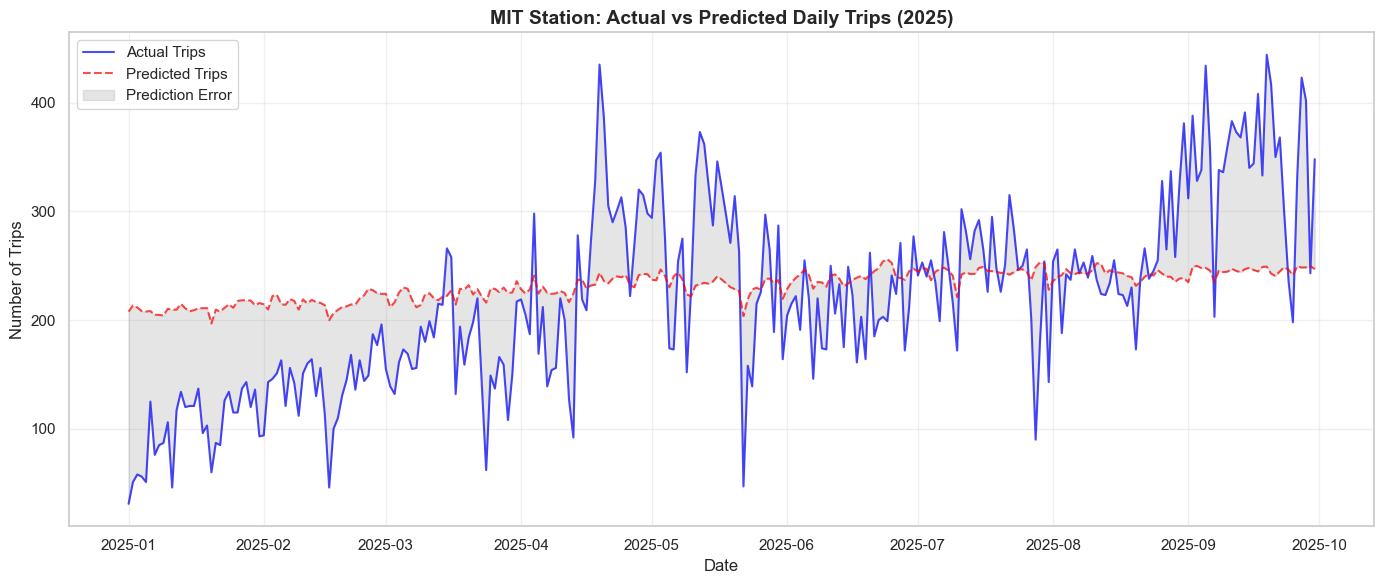

✓ Prediction comparison plot saved


In [17]:
# Visualize predictions over time for one station
mit_predictions_sorted = mit_predictions.sort_values('date')

plt.figure(figsize=(14, 6))
plt.plot(mit_predictions_sorted['date'], mit_predictions_sorted['trip_count'], 
         linewidth=1.5, alpha=0.7, color='blue', label='Actual Trips')
plt.plot(mit_predictions_sorted['date'], mit_predictions_sorted['predicted'], 
         linewidth=1.5, alpha=0.7, color='red', linestyle='--', label='Predicted Trips')
plt.fill_between(mit_predictions_sorted['date'], 
                  mit_predictions_sorted['trip_count'], 
                  mit_predictions_sorted['predicted'], 
                  alpha=0.2, color='gray', label='Prediction Error')
plt.title('MIT Station: Actual vs Predicted Daily Trips (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/predictions_vs_actual.png', dpi=200, bbox_inches='tight')
plt.show()

print("✓ Prediction comparison plot saved")

In [18]:
# Compare predictions across different stations on the same day
same_date = '2025-05-15'
same_day_data = test_results[test_results['date'] == same_date].copy()
same_day_data['predicted'] = same_day_data['predicted'].round(1)

print(f"Predictions for {same_date} (same weather, different stations):")
print(same_day_data.nlargest(10, 'predicted')[['start_station_name', 'trip_count', 'predicted']].to_string(index=False))

Predictions for 2025-05-15 (same weather, different stations):
                         start_station_name  trip_count  predicted
               MIT at Mass Ave / Amherst St         287      235.5
      Central Square at Mass Ave / Essex St         192      187.3
        Harvard Square at Mass Ave/ Dunster         125      167.3
             Beacon St at Massachusetts Ave         110      150.4
            MIT Pacific St at Purrington St         118      130.7
                  Newbury St at Hereford St          73      129.0
Charles Circle - Charles St at Cambridge St         113      121.9
                              MIT Vassar St         167      121.3
                         Ames St at Main St         116      116.3
                  Mass Ave/Lafayette Square         108      113.7


## Findings

While the model achieves R² = 0.731, visualizing predictions reveals that it captures overall trends but smooths over day-to-day volatility. This is expected for linear regression and represents the 27% unexplained variance - likely due to unmeasured factors like events, bike availability, and random variation in rider behavior.

**What's causing the smoothing?** Feature impact analysis revealed something interesting: including 608 station-specific dummy variables (station_id) lets the model learn each station's unique baseline demand, which is great for overall accuracy. But there's a tradeoff - the station ids basically absorb most of the day-to-day and seasonal patterns. Look at the coefficients: day_of_week only contributes ±2.5 trips, month only ±3.2 trips, while temperature swings ±58.6 trips. So predictions vary mostly with weather but stay pretty flat across different days and months within the same station.

Basically, each station learned "I'm typically busy/quiet" rather than learning the more nuanced "weekdays are way busier than weekends." The model knows MIT is a high-traffic station, but it doesn't distinguish Monday vs Saturday at MIT very well.

**How to fix this for the final report:**

1. **XGBoost (tree-based model):** This could be perfect for this problem. Unlike linear regression where all stations share the same day_of_week coefficient, trees can split on station_id first, then learn station-specific temporal patterns. So the model could learn "at MIT specifically, weekdays have 40+ more trips than weekends" rather than just "weekdays globally have 2.5 more trips." This should capture day-to-day volatility way better.

2. **Per-station linear models:** Train 608 separate models (one per station) so each location gets its own feature coefficients without the dummy variables dominating everything. This is computationally expensive and might overfit for low-traffic stations, but could be worth testing on high-volume stations like MIT first to see if it helps.